In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.signal import hilbert
from scipy import stats
from scipy.signal import butter, lfilter

from enfify.preprocessing import bandpass_filter
from enfify.enf_estimation import segmented_phase_estimation_DFT0, segmented_freq_estimation_DFT1
from enfify.enf_enhancement import VMD
from enfify.utils import read_wavfile

In [2]:

def hilbert_instantaneous_phase(signal):
    analytic_sig = hilbert(signal)
    inst_phase  = np.unwrap(np.angle(analytic_sig))
    return inst_phase

def segmented_phase_estimation_hilbert(s_in, f_s, num_cycles, nominal_enf):

    step_size = int(f_s // nominal_enf)

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    phases = []
    for i in range(len(segments)):
        phase = hilbert_instantaneous_phase(segments[i])
        phase = np.mean(phase)
        phases.append(phase)
    
    phases = np.unwrap(phases)
    phases = np.array(phases)
    
    return phases

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Apply butterworth bandpass filter

    Args:
        data (np.ndarray): input signal
        lowcut (float): low cut frequency
        highcut (float): high cut frequency
        fs (int): sampling rate
        order (int, optional): order of filter. Defaults to 5.

    Returns:
        y (np.ndarray): filtered signal
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y


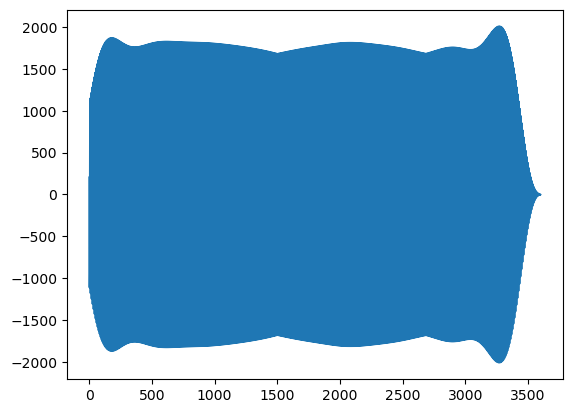

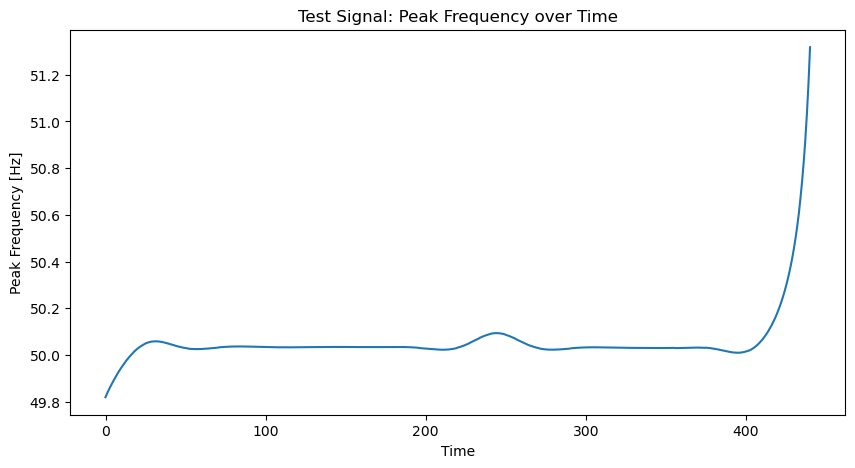

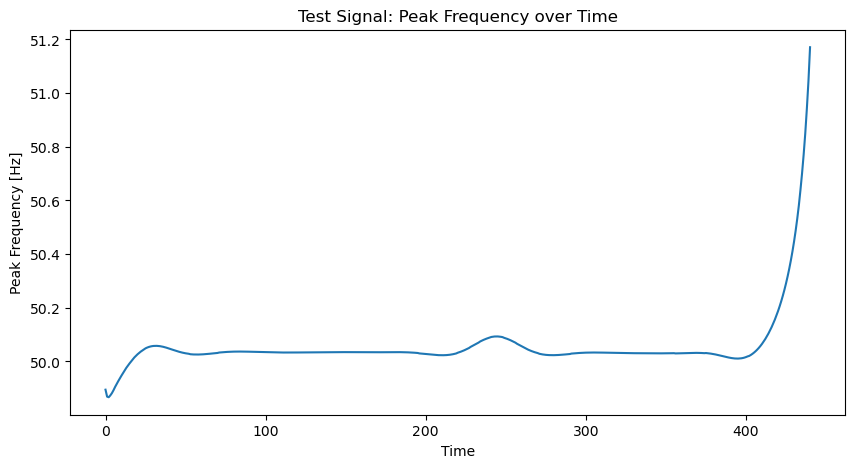

In [3]:
# 10 second Audio files
input_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/10s_ref/10s_enf_ref'
output_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/10s_ref/cut_10s_enf_ref'

file_list_uncut = os.listdir(input_dir)
file_list_cut = os.listdir(output_dir)

band_down_sig = []

for wav_file in file_list_uncut:
    file_path = os.path.join(input_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.9, 50.1, fs, 4)
    band_down_sig.append(bandpass_sig)

cut_band_down_sig = []
for wav_file in file_list_cut:
    file_path = os.path.join(output_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49, 51, fs, 4)
    cut_band_down_sig.append(bandpass_sig)


plt.plot(cut_band_down_sig[5])
plt.show()

peak_freqs = segmented_freq_estimation_DFT1(cut_band_down_sig[5], 400, num_cycles = 10, N_DFT= 20_000, nominal_enf=50)

# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(peak_freqs)),peak_freqs)
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time')
plt.title("Test Signal: Peak Frequency over Time")
plt.show()

alpha = 5000 # moderate bandwidth constraint
tau = 0 
n_mode = 1
DC = 0  # no DC part imposed  
tol = 1e-7
u_clean, u_hat_clean, omega_clean = VariationalModeDecomposition(cut_band_down_sig[5], alpha, tau, n_mode, DC, tol)

peak_freqs_vmd = segmented_freq_estimation_DFT1(u_clean[0], 400, num_cycles = 10, N_DFT= 20_000, nominal_enf=50)

# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(peak_freqs_vmd)), peak_freqs_vmd)
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time')
plt.title("Test Signal: Peak Frequency over Time")
plt.show()

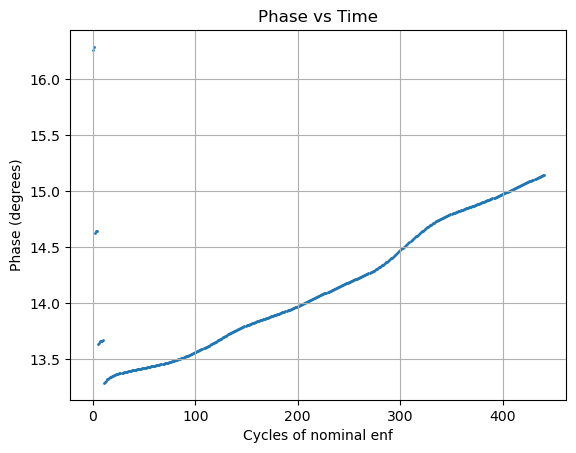

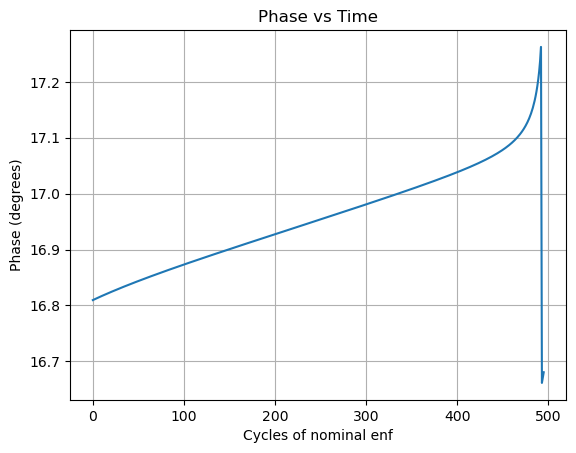

In [81]:
N_DFT = 20_000
NUM_CYCLES = 10

phases = segmented_phase_estimation_hilbert(cut_band_down_sig[5], fs, NUM_CYCLES, 50)

x = np.arange(len(phases))
plt.scatter(x, phases,s=1)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

N_DFT = 20_000
NUM_CYCLES = 5

phases = segmented_phase_estimation_hilbert(band_down_sig[5], fs, NUM_CYCLES, 50)

x = np.arange(len(phases))
plt.plot(x, phases)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

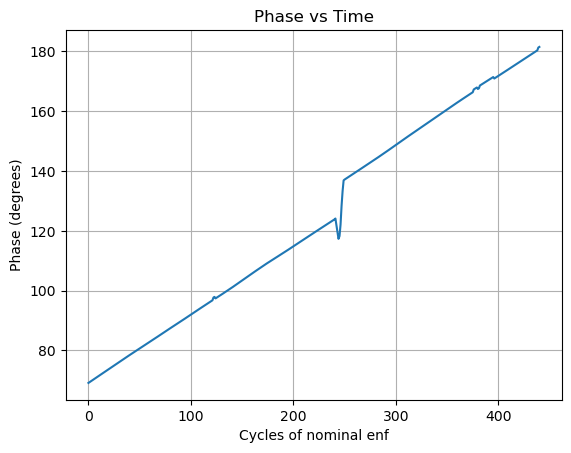

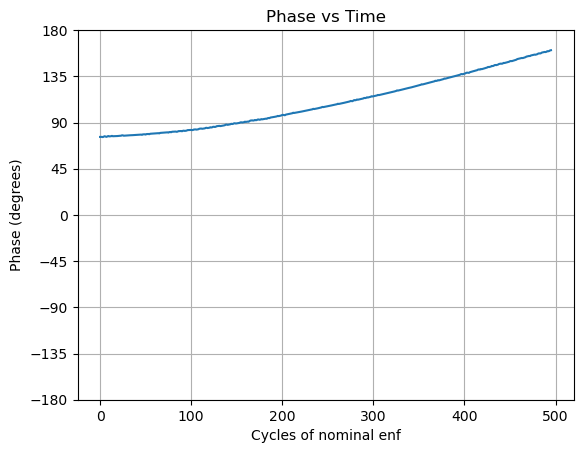

In [5]:
NUM_CYCLES = 10

phases = segmented_phase_estimation_DFT0(cut_band_down_sig[5], fs, NUM_CYCLES, N_DFT, 50)
#print(phases)

x = np.arange(len(phases))
plt.plot(x, np.degrees(phases))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
#plt.yticks(np.arange(-180, 181, 45))
#plt.ylim(-180, 180)
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

N_DFT = 20_000
NUM_CYCLES = 5

phases = segmented_phase_estimation_DFT0(band_down_sig[5], fs, NUM_CYCLES, N_DFT, 50)

x = np.arange(len(phases))
plt.plot(x, np.degrees(phases))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.yticks(np.arange(-180, 181, 45))
plt.ylim(-180, 180)
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

In [4]:
# 1min Audio files
input_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/1min_ref/1min_enf_ref_data'
output_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/1min_ref/cut_1min_enf_ref_data'

file_list_uncut = os.listdir(input_dir)
file_list_cut = os.listdir(output_dir)
fs = 400

band_down_sig = []
time = []
for wav_file in file_list_uncut:
    file_path = os.path.join(input_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    time.append(len(signal)/fs)
    bandpass_sig = bandpass_filter(signal, 99.9, 100.1, 400, 5)
    band_down_sig.append(signal)

cut_band_down_sig = []
cut_time = []
for wav_file in file_list_cut:
    file_path = os.path.join(output_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    cut_time.append(len(signal)/fs)
    bandpass_sig = bandpass_filter(signal, 99.9, 100.1, 400, 5)
    cut_band_down_sig.append(signal)

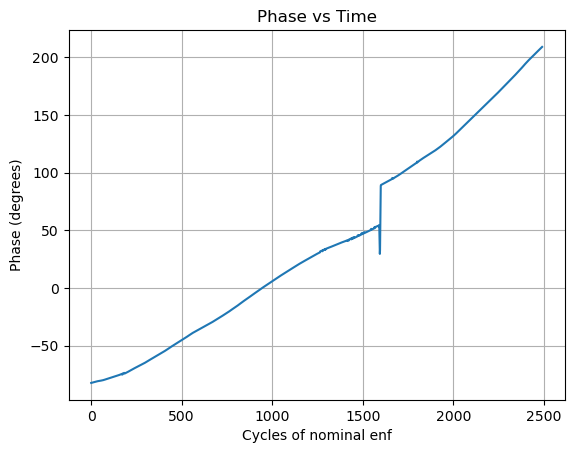

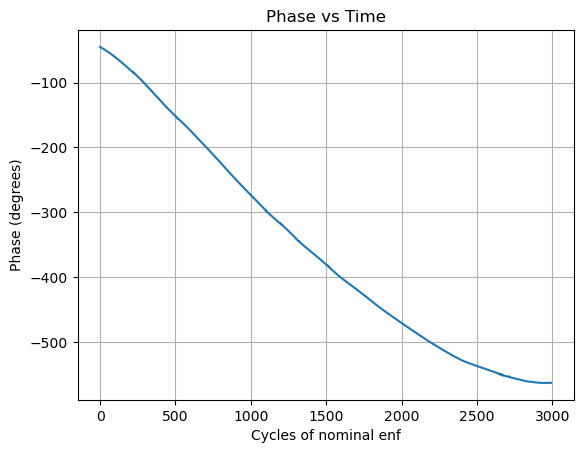

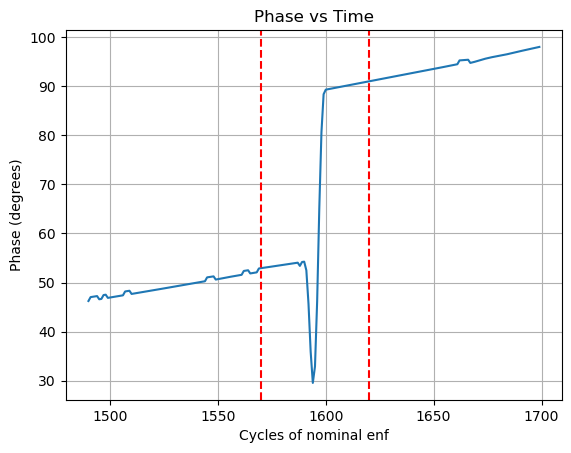

In [8]:
# DFT0
N_DFT = 20_000
NUM_CYCLES = 10

cut_phases = segmented_phase_estimation_DFT0(cut_band_down_sig[6], fs, NUM_CYCLES, N_DFT, 50)

x_cut = np.arange(len(cut_phases))
plt.plot(x_cut, np.degrees(cut_phases))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

N_DFT = 20_000
NUM_CYCLES = 10

phases = segmented_phase_estimation_DFT0(band_down_sig[6], fs, NUM_CYCLES, N_DFT, 50)

x = np.arange(len(phases))
plt.plot(x, np.degrees(phases))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

from scipy import stats

second_der = np.gradient(np.gradient(cut_phases,x_cut), x_cut)

z_scores = np.abs(stats.zscore(second_der))
ausreisser = np.where(z_scores > 3)

phases_cut_new = cut_phases[int(np.min(ausreisser))-100 : int(np.max(ausreisser))+100]
x_cut_new = x_cut[int(np.min(ausreisser))-100 : int(np.max(ausreisser))+100]

plt.plot(x_cut_new, np.degrees(phases_cut_new))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.axvline(x=int(np.min(ausreisser))-20, color='red', linestyle='--')
plt.axvline(x=int(np.max(ausreisser))+20, color='red', linestyle='--')
plt.grid(True)
plt.show()

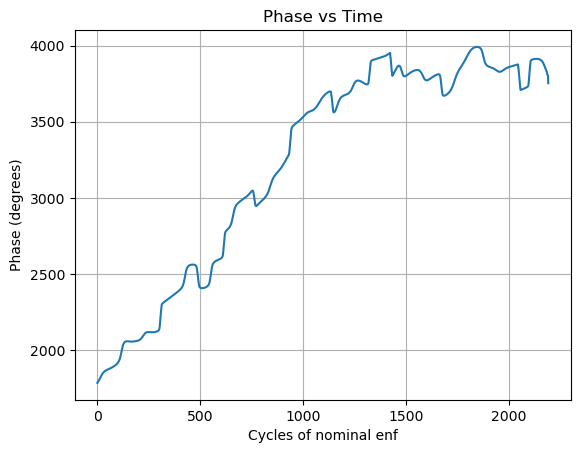

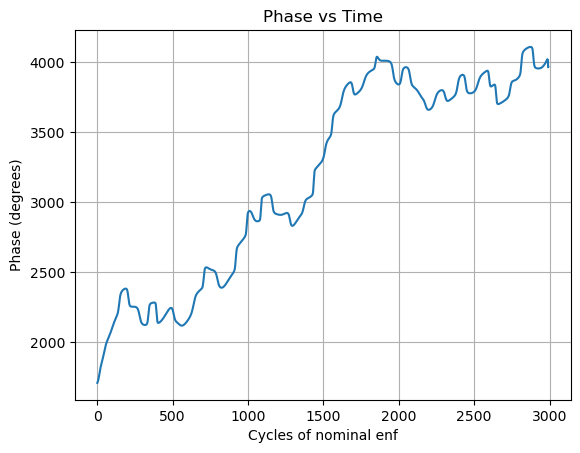

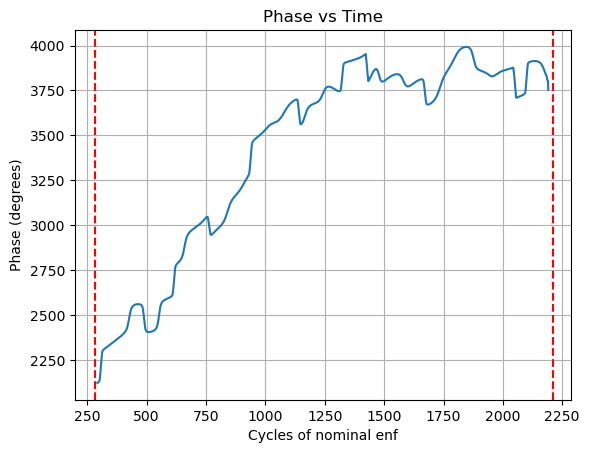

In [12]:
# 1min Audio files noisy data
input_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/1min_noise/1min_noisy_down'
output_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/1min_noise/1min_noisy_down_cut'

file_list_uncut = os.listdir(input_dir)
file_list_cut = os.listdir(output_dir)
fs = 1000

band_down_sig = []

for wav_file in file_list_uncut:
    file_path = os.path.join(input_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, 1000, 4)
    band_down_sig.append(bandpass_sig)

cut_band_down_sig = []
for wav_file in file_list_cut:
    file_path = os.path.join(output_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, 1000, 4)
    cut_band_down_sig.append(bandpass_sig)

N_DFT = 20_000
NUM_CYCLES = 10

phases_cut = segmented_phase_estimation_hilbert(cut_band_down_sig[2], fs, NUM_CYCLES, 50)
phases_cut = np.unwrap(phases_cut)

x_cut = np.arange(len(phases_cut))
plt.plot(x_cut, np.degrees(phases_cut))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

N_DFT = 20_000
NUM_CYCLES = 10

phases = segmented_phase_estimation_hilbert(band_down_sig[1], fs, NUM_CYCLES, 50)

x = np.arange(len(phases))
plt.plot(x, np.degrees(phases))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()


second_der = np.gradient(np.gradient(phases_cut,x_cut), x_cut)

z_scores = np.abs(stats.zscore(second_der))

ausreisser = np.where(z_scores > 3)

phases_cut_new = phases_cut[int(np.min(ausreisser))-10 : int(np.max(ausreisser))+10]
x_cut_new = x_cut[int(np.min(ausreisser))-10 : int(np.max(ausreisser))+10]

plt.plot(x_cut_new, np.degrees(phases_cut_new))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.axvline(x=int(np.min(ausreisser))-20, color='red', linestyle='--')
plt.axvline(x=int(np.max(ausreisser))+20, color='red', linestyle='--')
plt.grid(True)
plt.show()